In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/PPE Detection/venv/lib/python3.10/site-packages')

In [3]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
import random
import pickle
from PIL import Image
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error

seed(1)
tf.random.set_seed(1)

In [5]:
%run '/content/drive/MyDrive/Colab Notebooks/PPE Detection/notebook/utils.ipynb'

In [6]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/PPE Detection/dataset'

SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 2

In [ ]:
train_generator = data_generator(dataset_path+'/test', batch_size=BATCH_SIZE)
im, l, b = next(train_generator)

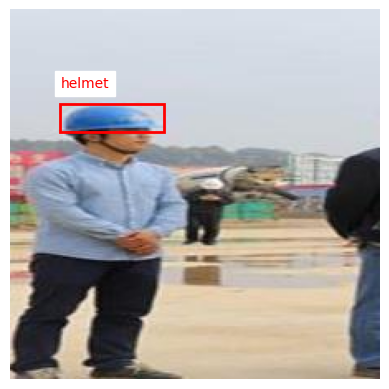

In [ ]:
index = random.randint(0, BATCH_SIZE-1)
image = im[index]
lab = l[index]
box = b[index]
draw(Image.fromarray(image.astype(np.uint8)), box*224, np.argmax(lab) )

#**Class definition**

In [ ]:
EPOCHS=100

In [ ]:
class standardCNN:

  def __init__(self, train=None, test=None, val=None, name='standardCNN'):
    # set datasets
    self.train_path, self.val_path, self.test_path = train, val, test
    self.name=name
    self.history = None
    self.model = self.build_model()
    self.epochs = EPOCHS

    self.dir_name ="/content/drive/MyDrive/Colab Notebooks/PPE Detection/models/CNN"
    if not os.path.exists(self.dir_name):
      os.makedirs(self.dir_name)
    self.save_path = os.path.join(self.dir_name, name+'.h5')

    self.callbacks_list = [
      ks.callbacks.ModelCheckpoint(
          filepath=self.save_path,
          monitor="val_loss", #sum of the classification and regression losses
          verbose=1,
          save_best_only=True)
      ]

  def build_model(self):
    input = ks.Input(shape=(SIZE, SIZE, 3))
    x = layers.Rescaling(1. / 255)(input)

    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")(input)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)

    #x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=128, activation='relu')(x)
    x = layers.Dense(units=64, activation='relu')(x)

    label_output = layers.Dense(units= NUM_CLASSES, activation='softmax', name='classifier')(x)
    bbox_output = layers.Dense(units=4, activation='sigmoid', name='regressor')(x)
    outputs = [label_output, bbox_output]

    return ks.Model(inputs=input, outputs=outputs)

  def compile_and_fit(self, optimizer='adam', learning_rate=None):
    if learning_rate is not None:
        optimizer.learning_rate = learning_rate

    self.model.compile(
        optimizer=optimizer,
        loss={'classifier': categorical_crossentropy,
                 'regressor': mean_squared_error},
        loss_weights={'classifier': 1.0,
                 'regressor': 15.0},
        metrics={'classifier': 'accuracy',
                 'regressor': IoU_metric},
    )

    train_data_generator = data_generator(self.train_path, batch_size=BATCH_SIZE)
    val_data_generator = data_generator(self.val_path, batch_size=BATCH_SIZE)

    train_data, train_labels, train_boxes = next(train_data_generator)
    val_data, val_labels, val_boxes = next(val_data_generator)


    self.history = self.model.fit(
        train_data,
        [train_labels, train_boxes],
        steps_per_epoch=len(train_data) // BATCH_SIZE,
        epochs=self.epochs,
        validation_data=(val_data, [val_labels, val_boxes]),
        validation_steps=len(val_data) // BATCH_SIZE,
        shuffle=True,
        callbacks=self.callbacks_list
    )

    self.save_history()

  def plot_model(self, model_name):
    ks.utils.plot_model(self.model, to_file=str(model_name) +".jpg", show_shapes=True)

  def load_best_model(self):
    custom_objects = {'IoU_metric': IoU_metric}
    self.model = ks.models.load_model(self.save_path, custom_objects=custom_objects)

  def save_history(self):
    with open(os.path.join(self.dir_name, self.name), 'wb') as file_pi:
      pickle.dump(self.history.history, file_pi)

  def load_history(self):
    with open(os.path.join(self.dir_name, self.name), 'rb') as file_pi:
      history = pickle.load(file_pi)
    self.history = history

  def load(self):
    self.load_best_model()
    self.load_history()

  def evaluate(self, test=None):
    if test is None:
        test = self.test_path
        test_data_generator = data_generator(test, batch_size=BATCH_SIZE)

    test_data, test_labels, test_boxes = [], [], []

    for batch_data, batch_labels, batch_boxes in test_data_generator:
      if (len(batch_data)==BATCH_SIZE and len(batch_labels)==BATCH_SIZE):
        test_data.append(batch_data)
        test_labels.append(batch_labels)
        test_boxes.append(batch_boxes)

    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_boxes = np.concatenate(test_boxes, axis=0)

    test_loss, classifier_loss, regressor_loss, classifier_accuracy, regressor_iou = self.model.evaluate(test_data, [test_labels, test_boxes], verbose=0)
    print(f"Test loss: {test_loss:.3f}")
    print(f"Classifier loss: {classifier_loss:.3f}\n")
    print(f"Regressor loss: {regressor_loss:.3f}")
    print(f"Classifier accuracy: {classifier_accuracy:.3f}")
    print(f"Regressor IoU: {regressor_iou:.3f}")


  def predict(self, test=None):
    if test is None:
        test = self.test_path
        test_data_generator = data_generator(test, batch_size=BATCH_SIZE)

    test_data, test_labels, test_boxes = [], [], []

    for batch_data, batch_labels, batch_boxes in test_data_generator:
      if (len(batch_data)==BATCH_SIZE and len(batch_labels)==BATCH_SIZE):
        test_data.append(batch_data)
        test_labels.append(batch_labels)
        test_boxes.append(batch_boxes)

    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_boxes = np.concatenate(test_boxes, axis=0)

    predictions = self.model.predict(test_data)
    test_labels = np.argmax(test_labels, axis=1)

    return test_data, predictions, test_labels, test_boxes

  def summary(self):
      self.model.summary()

# CNN Base Model

##Model representation


In [ ]:
base_model = standardCNN(train=dataset_path+'/train', val=dataset_path+'/valid', test=dataset_path+'/test')
base_model.summary()
base_model.plot_model(model_name="standardCNN")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 32)           4640      ['max_pooling2d[0][0]']   

##Model compile and fit

In [ ]:
base_model.compile_and_fit()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.4178 - classifier_loss: 0.8004 - regressor_loss: 0.0514 - classifier_accuracy: 0.7656 - regressor_IoU_metric: 0.2612
Epoch 1: val_loss did not improve from 0.91720
1/1 [==============================] - 3s 3s/step - loss: 1.4178 - classifier_loss: 0.8004 - regressor_loss: 0.0514 - classifier_accuracy: 0.7656 - regressor_IoU_metric: 0.2612 - val_loss: 6.2874 - val_classifier_loss: 4.0186 - val_regressor_loss: 0.1891 - val_classifier_accuracy: 0.5625 - val_regressor_IoU_metric: 0.0778
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 7.5471 - classifier_loss: 5.4481 - regressor_loss: 0.1749 - classifier_accuracy: 0.4531 - regressor_IoU_metric: 0.0582
Epoch 2: val_loss did not improve from 0.91720
1/1 [==============================] - 0s 122ms/step - loss: 7.5471 - classifier_loss: 5.4481 - regressor_loss: 0.1749 - classifier_accuracy: 0.4531 - regressor_IoU_metric: 0.0582 - val_loss: 1.6158 - val_class

## Visualize results

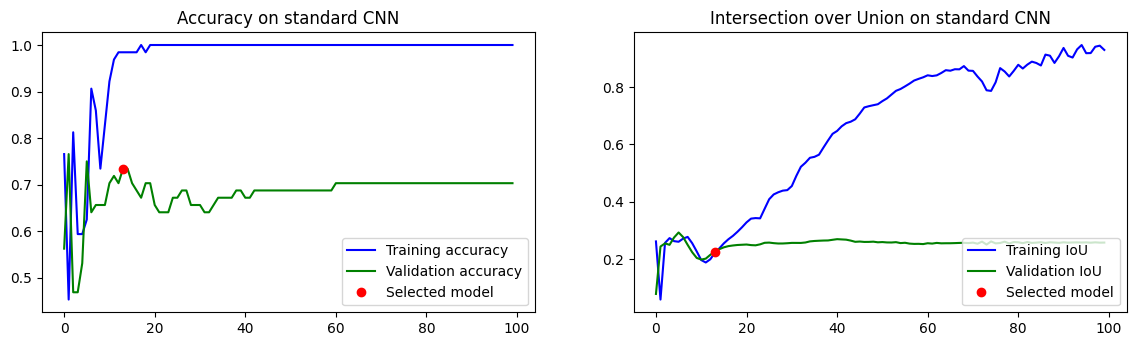

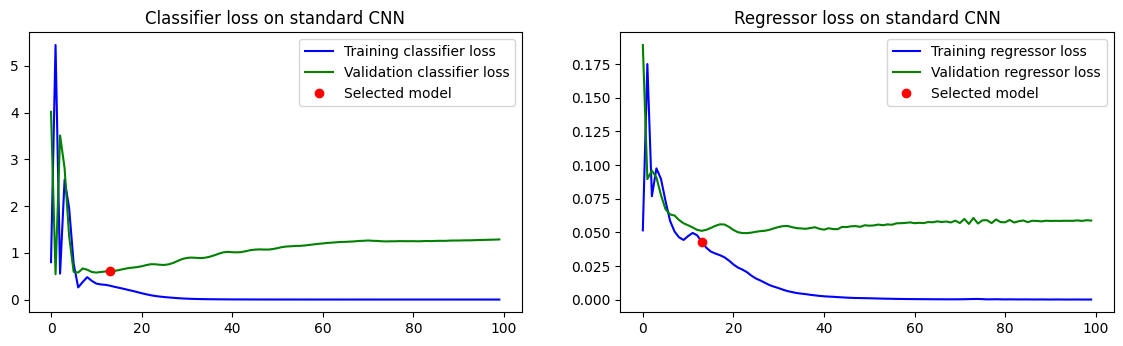

Lowest validation loss has been reached at epoch 13 with:
Training accuracy of 0.984 and Validation accuracy of 0.734 
Training IoU of 0.221 and Validation IoU of 0.226



<Figure size 640x480 with 0 Axes>

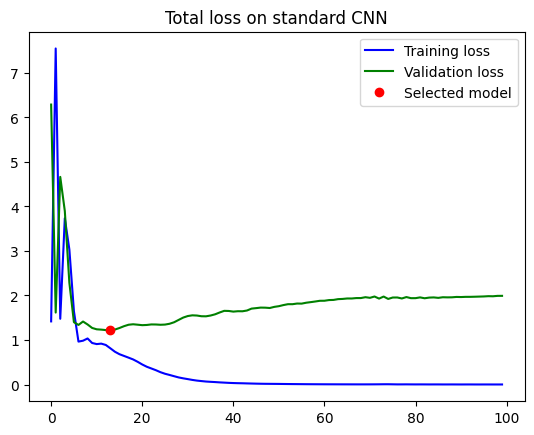

In [ ]:
history = base_model.history.history if base_model.history is not None else (base_model.load() or base_model.history)
visualize_results('standard CNN', history)

## Evaluate against test set

In [ ]:
base_model.evaluate()

Test loss: 1.940
Classifier loss: 1.183

Regressor loss: 0.063
Classifier accuracy: 0.703
Regressor IoU: 0.190


In [ ]:
test_data, predictions, actual_labels, actual_boxes = base_model.predict()
pred_labels = [np.argmax(pred) for pred in predictions[0]]
pred_boxes = predictions[1]

6/6 [==============================] - 7s 12ms/step


Actual label:  vest


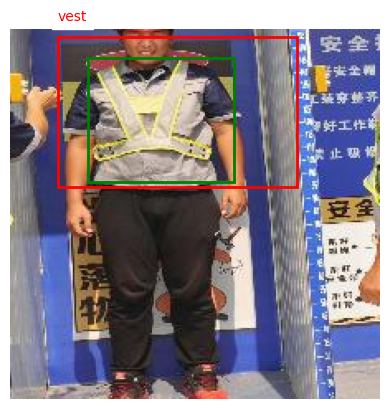

In [ ]:
from PIL import ImageDraw

index = random.randint(0, len(test_data)-1)
image = Image.fromarray(test_data[index].astype(np.uint8))
predictions[0]
pred_label = pred_labels[index]
pred_box = pred_boxes[index]
actual_label = actual_labels[index]
actual_box = actual_boxes[index]

draw(image, pred_box*224, pred_label, actual_box*224, actual_label)

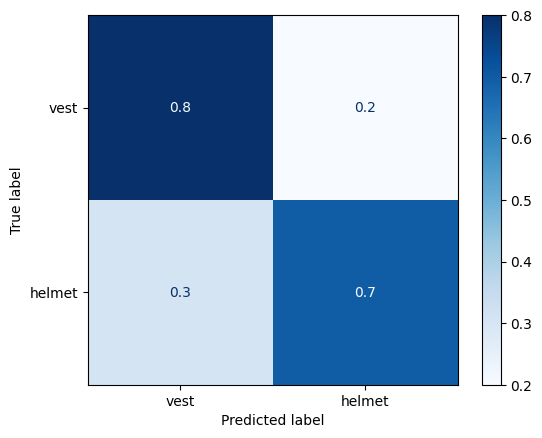

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
result = confusion_matrix(actual_labels, pred_labels, normalize='true')#normalize='true'
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['vest', 'helmet'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Considerations


#CNN Base model with GlobalAveragePooling

In [ ]:
EPOCHS=100

In [ ]:
base_model2 = standardCNN(train=dataset_path+'/train', val=dataset_path+'/valid', test=dataset_path+'/test', name='standardCNN_GAP')
base_model2.summary()
base_model2.plot_model(model_name="standardCNN_GAP")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 224, 224, 16)         448       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 16)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 56, 56, 32)           4640      ['max_pooling2d_3[0][0]'

##Model compile and fit

In [ ]:
base_model2.compile_and_fit()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 5.3551 - classifier_loss: 0.9913 - regressor_loss: 0.3637 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 0.0000e+00
Epoch 1: val_loss improved from inf to 9.59310, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/CNN/standardCNN_GAP.h5
1/1 [==============================] - 4s 4s/step - loss: 5.3551 - classifier_loss: 0.9913 - regressor_loss: 0.3637 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 0.0000e+00 - val_loss: 9.5931 - val_classifier_loss: 5.9190 - val_regressor_loss: 0.3062 - val_classifier_accuracy: 0.5000 - val_regressor_IoU_metric: 0.0000e+00
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 9.5076 - classifier_loss: 6.1045 - regressor_loss: 0.2836 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 9.59310 to 3.47777, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/CNN/standardCNN_GAP.h5
1/1 [==============================] - 0s 202ms/step - loss: 9.5076 - classifier_loss: 6.1045 - regressor_loss: 0.2836 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 0.0000e+00 - val_loss: 3.4778 - val_classifier_loss: 1.1342 - val_regressor_loss: 0.1953 - val_classifier_accuracy: 0.5000 - val_regressor_IoU_metric: 0.0000e+00
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 3.5312 - classifier_loss: 1.2358 - regressor_loss: 0.1913 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 0.0000e+00
Epoch 3: val_loss improved from 3.47777 to 2.98359, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/CNN/standardCNN_GAP.h5
1/1 [==============================] - 0s 214ms/step - loss: 3.5312 - classifier_loss: 1.2358 - regressor_loss: 0.1913 - classifier_accuracy: 0.5000 - regressor_IoU_metric:

## Visualize results

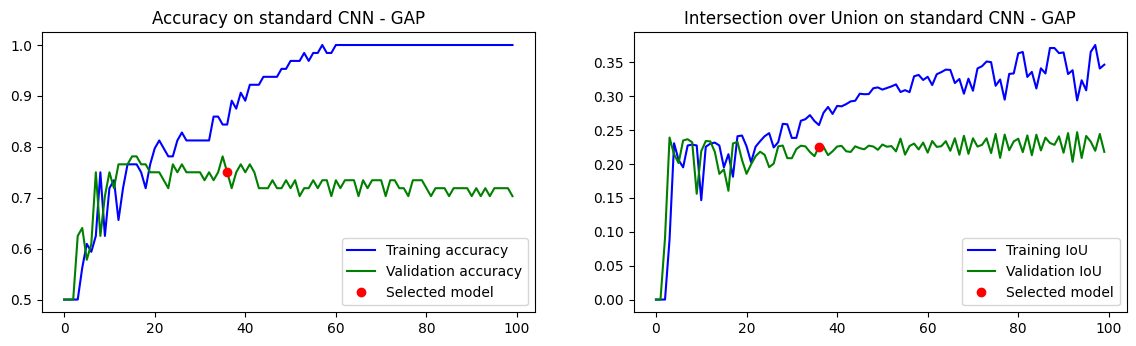

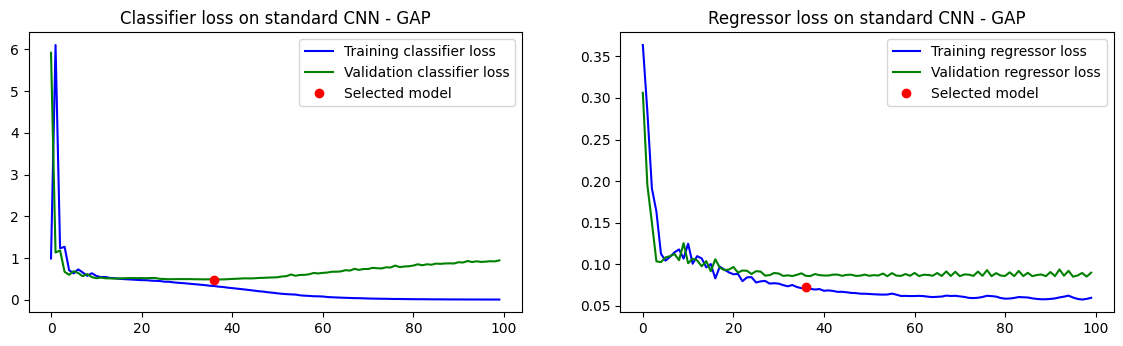

Lowest validation loss has been reached at epoch 36 with:
Training accuracy of 0.844 and Validation accuracy of 0.750 
Training IoU of 0.257 and Validation IoU of 0.225



<Figure size 640x480 with 0 Axes>

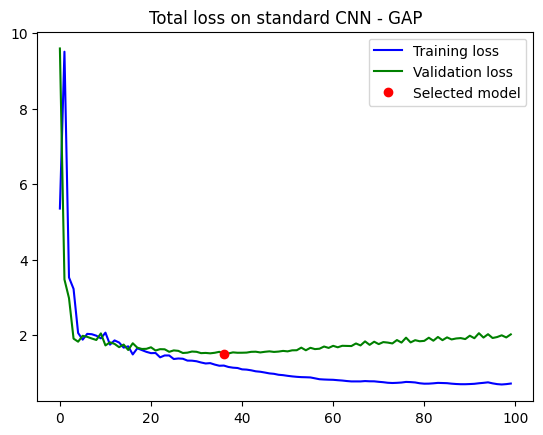

In [ ]:
history = base_model2.history.history if base_model2.history is not None else (base_model2.load() or base_model2.history)
visualize_results('standard CNN - GAP', history)

## Evaluate against test set

In [ ]:
base_model2.evaluate()

Test loss: 1.971
Classifier loss: 0.833

Regressor loss: 0.095
Classifier accuracy: 0.740
Regressor IoU: 0.209


In [ ]:
test_data, predictions, actual_labels, actual_boxes = base_model2.predict()
pred_labels = [np.argmax(pred) for pred in predictions[0]]
pred_boxes = predictions[1]

6/6 [==============================] - 0s 26ms/step


Actual label:  helmet


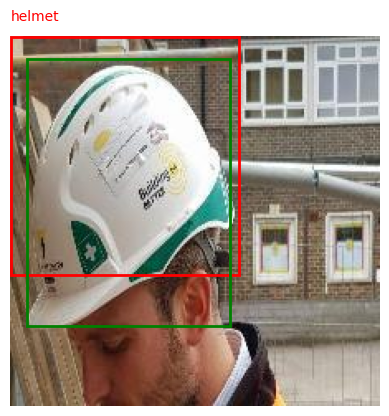

In [ ]:
from PIL import ImageDraw

index = random.randint(0, len(test_data)-1)
image = Image.fromarray(test_data[index].astype(np.uint8))
predictions[0]
pred_label = pred_labels[index]
pred_box = pred_boxes[index]
actual_label = actual_labels[index]
actual_box = actual_boxes[index]

draw(image, pred_box*224, pred_label, actual_box*224, actual_label)

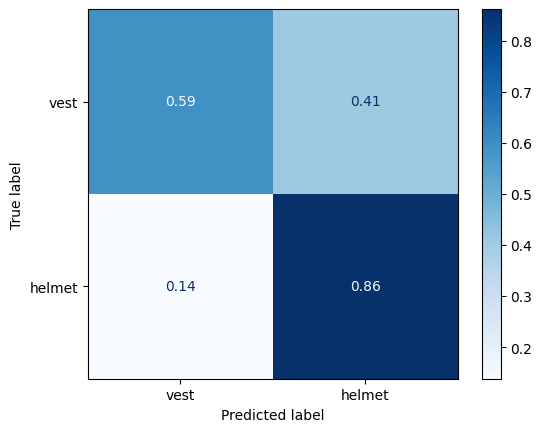

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
result = confusion_matrix(actual_labels, pred_labels, normalize='true')#normalize='true'
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['vest', 'helmet'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# CNN with Dropout

In [ ]:
EPOCHS=400
DROPOUT_RATE = 0.5

In [ ]:
class dropoutCNN(standardCNN):

  def __init__(self, dropout=None, train=None, test=None, val=None, name='dropoutCNN'):
      super().__init__(train=train, test=test, val=val, name=name)

  def build_model(self):
    input = ks.Input(shape=(SIZE, SIZE, 3))
    x = layers.Rescaling(1. / 255)(input)

    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")(input)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(units=128, activation='relu')(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Dense(units=64, activation='relu')(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    label_output = layers.Dense(units= NUM_CLASSES, activation='softmax', name='classifier')(x)
    bbox_output = layers.Dense(units=4, activation='sigmoid', name='regressor')(x)
    outputs = [label_output, bbox_output]

    return ks.Model(inputs=input, outputs=outputs)

##Model representation


In [ ]:
dropout_model = dropoutCNN(train=dataset_path+'/train', val=dataset_path+'/valid', test=dataset_path+'/test')
dropout_model.summary()
dropout_model.plot_model(model_name="dropoutCNN")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 224, 224, 16)         448       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 16)           0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 56, 56, 32)           4640      ['max_pooling2d_6[0][0]'

##Model compile and fit

In [ ]:
dropout_model.compile_and_fit()

Epoch 1/400
1/1 [==============================] - ETA: 0s - loss: 19.7605 - classifier_loss: 15.1777 - regressor_loss: 0.3525 - classifier_accuracy: 0.3750 - regressor_IoU_metric: 0.0013
Epoch 1: val_loss improved from inf to 5.03765, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/CNN/dropoutCNN.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 16s 16s/step - loss: 19.7605 - classifier_loss: 15.1777 - regressor_loss: 0.3525 - classifier_accuracy: 0.3750 - regressor_IoU_metric: 0.0013 - val_loss: 5.0377 - val_classifier_loss: 2.6858 - val_regressor_loss: 0.1809 - val_classifier_accuracy: 0.4219 - val_regressor_IoU_metric: 0.0302
Epoch 2/400
1/1 [==============================] - ETA: 0s - loss: 9.3526 - classifier_loss: 6.0186 - regressor_loss: 0.2565 - classifier_accuracy: 0.4844 - regressor_IoU_metric: 0.0232
Epoch 2: val_loss improved from 5.03765 to 1.82846, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/CNN/dropoutCNN.h5
1/1 [==============================] - 0s 200ms/step - loss: 9.3526 - classifier_loss: 6.0186 - regressor_loss: 0.2565 - classifier_accuracy: 0.4844 - regressor_IoU_metric: 0.0232 - val_loss: 1.8285 - val_classifier_loss: 0.6908 - val_regressor_loss: 0.0875 - val_classifier_accuracy: 0.6094 - val_regressor_IoU_metric: 0.2262
Epoch 3/400
1

## Visualize results

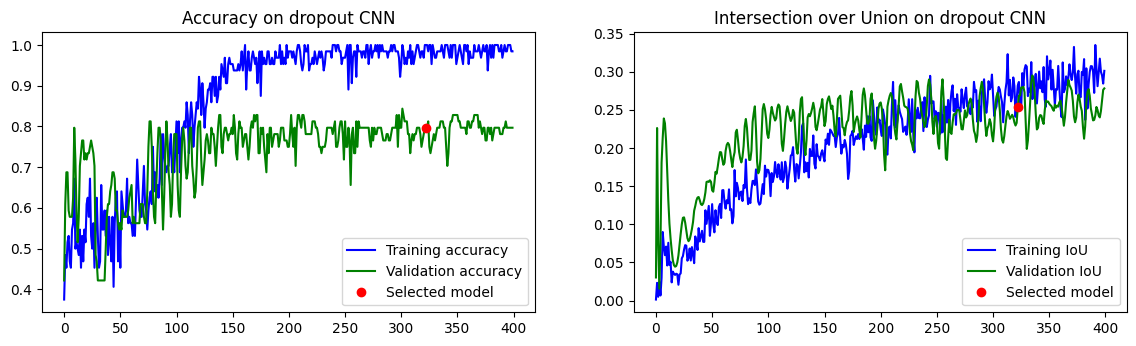

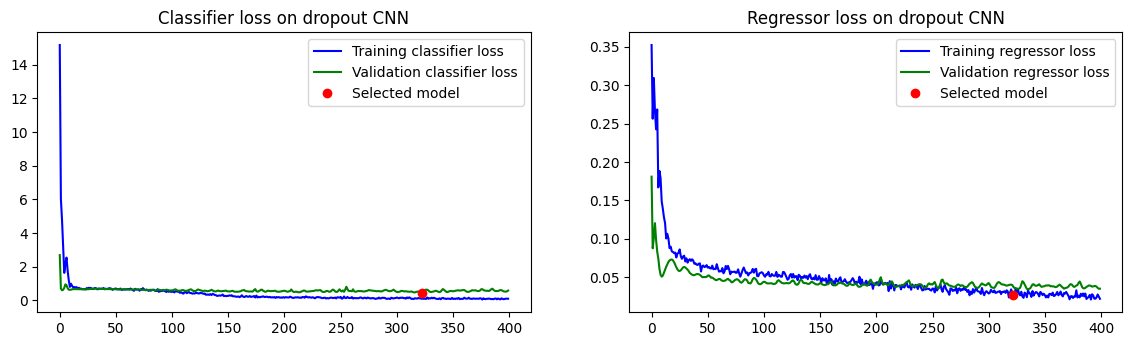

Lowest validation loss has been reached at epoch 322 with:
Training accuracy of 1.000 and Validation accuracy of 0.797 
Training IoU of 0.282 and Validation IoU of 0.254



<Figure size 640x480 with 0 Axes>

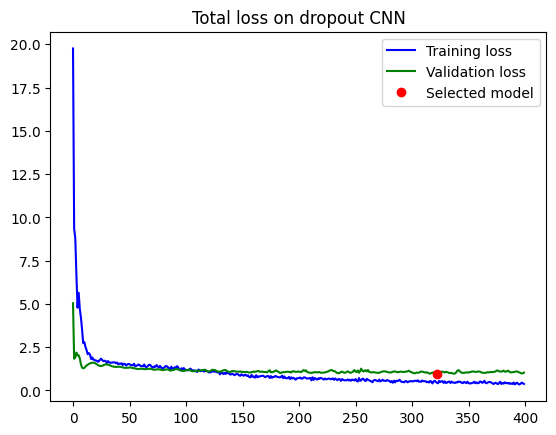

In [ ]:
history = dropout_model.history.history if dropout_model.history is not None else (dropout_model.load() or dropout_model.history)
visualize_results('dropout CNN', history)

## Evaluate against test set

In [ ]:
dropout_model.evaluate()

Test loss: 1.018
Classifier loss: 0.473

Regressor loss: 0.042
Classifier accuracy: 0.786
Regressor IoU: 0.223


In [ ]:
test_data, predictions, actual_labels, actual_boxes = dropout_model.predict()
pred_labels = [np.argmax(pred) for pred in predictions[0]]
pred_boxes = predictions[1]

6/6 [==============================] - 0s 13ms/step


Actual label:  vest


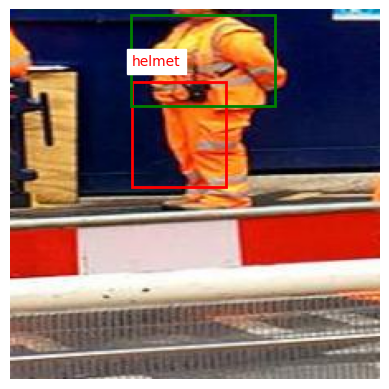

In [ ]:
from PIL import ImageDraw

index = random.randint(0, len(test_data)-1)
image = Image.fromarray(test_data[index].astype(np.uint8))
predictions[0]
pred_label = pred_labels[index]
pred_box = pred_boxes[index]
actual_label = actual_labels[index]
actual_box = actual_boxes[index]

draw(image, pred_box*224, pred_label, actual_box*224, actual_label)

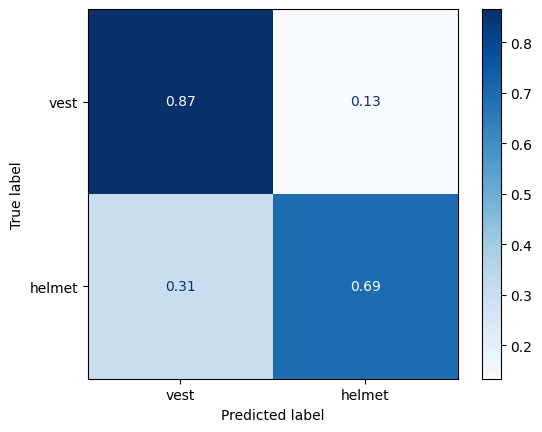

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
result = confusion_matrix(actual_labels, pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['vest', 'helmet'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# CNN - Hyperparameters Tuning

## Model definition

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
EPOCHS = 400

In [ ]:
import keras_tuner as kt

class TuningCNN(standardCNN):

  def __init__(self, dropout=None, train=None, test=None, val=None, name='Tuning CNN'):
    super().__init__(train=train, test=test, val=val, name=name)

    self.log_dir = os.path.join(self.dir_name, 'tuning_log')
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)

  def build_tuned_model(self, hp):
    input = ks.Input(shape=(SIZE, SIZE, 3))
    input = layers.Rescaling(1. / 255)(input)

    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.8, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss_weight_classifier = hp.Float('loss_weight_classifier', min_value=1.0, max_value=10.0, step=1.0)
    hp_loss_weight_regressor = hp.Float('loss_weight_regressor', min_value=10.0, max_value=20.0, step=1.0)

    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")(input)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(hp_dropout)(x)

    label_output = layers.Dense(units=NUM_CLASSES, activation='softmax', name='classifier')(x)
    bbox_output = layers.Dense(units=4, activation='sigmoid', name='regressor')(x)
    outputs = [label_output, bbox_output]

    model = ks.Model(inputs=input, outputs=outputs)
    model.compile(
        optimizer=ks.optimizers.Adam(learning_rate=hp_learning_rate),
        loss={'classifier': categorical_crossentropy,
                 'regressor': mean_squared_error},
        loss_weights={'classifier': hp_loss_weight_classifier,
                      'regressor': hp_loss_weight_classifier},
        metrics={'classifier': 'accuracy',
                 'regressor': IoU_metric},
    )

    return model

  def tuning(self, optimizer='adam'):
    tuner = kt.Hyperband(
        self.build_tuned_model,
        objective=kt.Objective("val_loss", direction="min"),
        max_epochs=20,
        factor=3,
        directory=self.log_dir,
        project_name='mobilenet_tuning'
    )
    tuner.search_space_summary()

    train_data_generator = data_generator(self.train_path, batch_size=BATCH_SIZE)
    val_data_generator = data_generator(self.val_path, batch_size=BATCH_SIZE)

    train_data, train_labels, train_boxes = next(train_data_generator)
    val_data, val_labels, val_boxes = next(val_data_generator)


    tuner.search(
        train_data,
        {"classifier": train_labels, "regressor": train_boxes},
        epochs=10,
        validation_data=(val_data, [val_labels, val_boxes]),
        callbacks=[ks.callbacks.TensorBoard(self.log_dir)]
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"The hyperparameter search is complete. \
        The optimal hyperparameters are as follows:\n\
        - Learning rate for the optimizer: {best_hps.get('learning_rate')}\n\
        - Dropout rate: {best_hps.get('dropout')}\n\
        - Loss weight for classifier: {best_hps.get('loss_weight_classifier')}\n\
        - Loss weight for regressor: {best_hps.get('loss_weight_regressor')}")

    self.model = tuner.hypermodel.build(best_hps)

##Model representation


In [ ]:
tuning_model = TuningCNN(train=dataset_path+'/train', val=dataset_path+'/valid', test=dataset_path+'/test')

In [ ]:
tuning_model.tuning()

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss_weight_classifier (Float)
{'default': 1.0, 'conditions': [], 'min_value': 1.0, 'max_value': 10.0, 'step': 1.0, 'sampling': 'linear'}
loss_weight_regressor (Float)
{'default': 10.0, 'conditions': [], 'min_value': 10.0, 'max_value': 20.0, 'step': 1.0, 'sampling': 'linear'}
The hyperparameter search is complete.         The optimal hyperparameters are as follows:
        - Learning rate for the optimizer: 0.0001
        - Dropout rate: 0.4
        - Loss weight for classifier: 1.0
        - Loss 

In [ ]:
tuning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 224, 224, 16)         448       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 16)           0         ['conv2d_4[1][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 56, 56, 32)           4640      ['max_pooling2d_3[1][0]'

##Model compile and fit

In [ ]:
tuning_model.compile_and_fit()

Epoch 1/400
1/1 [==============================] - ETA: 0s - loss: 15.2367 - classifier_loss: 9.7122 - regressor_loss: 0.3946 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 2.7675e-04
Epoch 1: val_loss improved from inf to 3.39032, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/CNN/Tuning CNN.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 13s 13s/step - loss: 15.2367 - classifier_loss: 9.7122 - regressor_loss: 0.3946 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 2.7675e-04 - val_loss: 3.3903 - val_classifier_loss: 0.9056 - val_regressor_loss: 0.1775 - val_classifier_accuracy: 0.4844 - val_regressor_IoU_metric: 0.0117
Epoch 2/400
1/1 [==============================] - ETA: 0s - loss: 7.4926 - classifier_loss: 3.4075 - regressor_loss: 0.2918 - classifier_accuracy: 0.4375 - regressor_IoU_metric: 0.0095
Epoch 2: val_loss did not improve from 3.39032
1/1 [==============================] - 0s 141ms/step - loss: 7.4926 - classifier_loss: 3.4075 - regressor_loss: 0.2918 - classifier_accuracy: 0.4375 - regressor_IoU_metric: 0.0095 - val_loss: 3.4470 - val_classifier_loss: 1.7375 - val_regressor_loss: 0.1221 - val_classifier_accuracy: 0.4531 - val_regressor_IoU_metric: 0.2045
Epoch 3/400
1/1 [==============================] - ETA: 0s - loss: 7.1132 - classifier_loss: 3.6053 - regress

## Visualize results

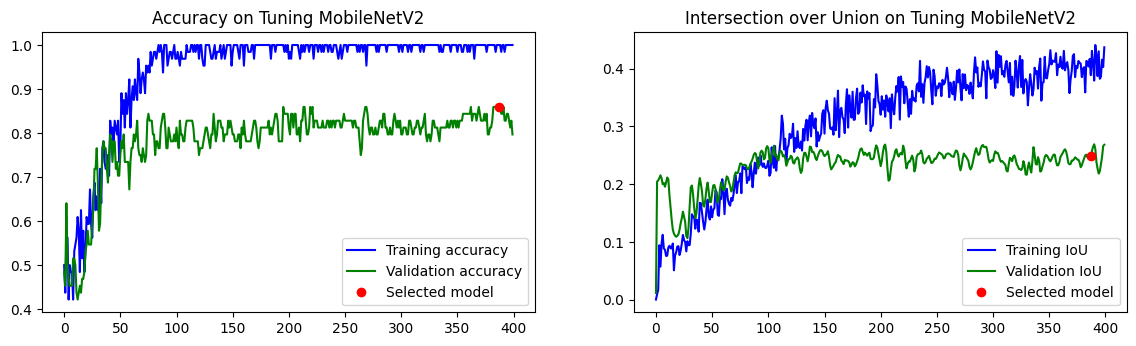

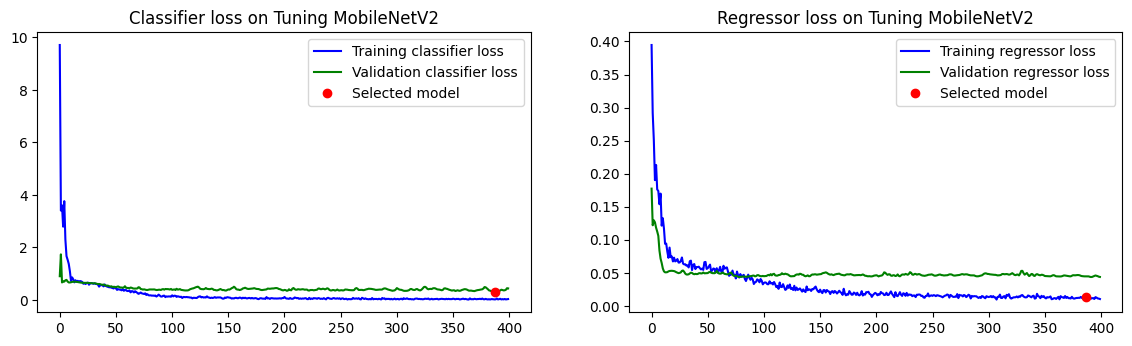

Lowest validation loss has been reached at epoch 387 with:
Training accuracy of 1.000 and Validation accuracy of 0.859 
Training IoU of 0.389 and Validation IoU of 0.249



<Figure size 640x480 with 0 Axes>

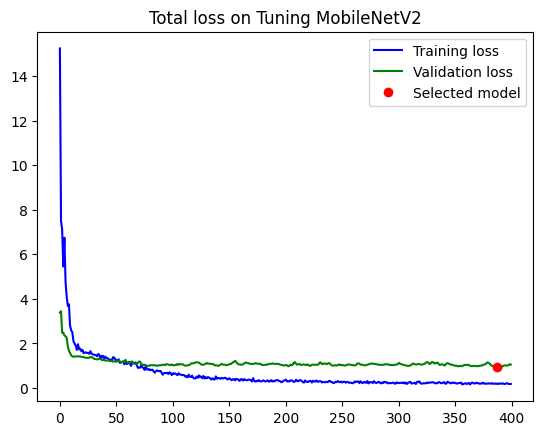

In [ ]:
history = tuning_model.history.history if tuning_model.history is not None else (tuning_model.load() or tuning_model.history)
visualize_results('Tuning MobileNetV2', history)

## Evaluate against test set

In [ ]:
tuning_model.evaluate()

Test loss: 1.278
Classifier loss: 0.662

Regressor loss: 0.044
Classifier accuracy: 0.781
Regressor IoU: 0.259


In [ ]:
test_data, predictions, actual_labels, actual_boxes = tuning_model.predict()
pred_labels = [np.argmax(pred) for pred in predictions[0]]
pred_boxes = predictions[1]

6/6 [==============================] - 1s 29ms/step


Actual label:  vest


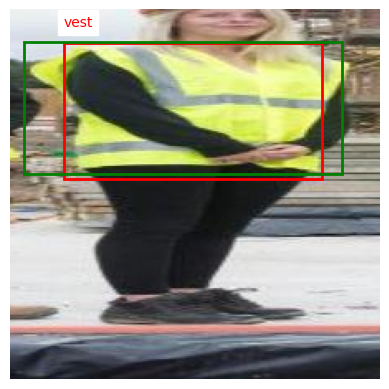

In [ ]:
from PIL import ImageDraw

index = random.randint(0, len(test_data)-1)
image = Image.fromarray(test_data[index].astype(np.uint8))
predictions[0]
pred_label = pred_labels[index]
pred_box = pred_boxes[index]
actual_label = actual_labels[index]
actual_box = actual_boxes[index]

draw(image, pred_box*224, pred_label, actual_box*224, actual_label)

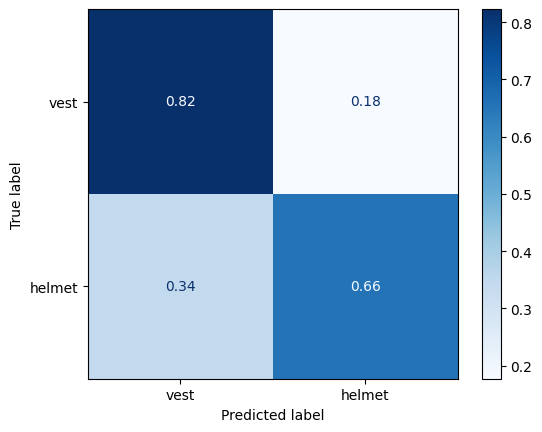

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
result = confusion_matrix(actual_labels, pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['vest', 'helmet'])
disp.plot(cmap=plt.cm.Blues)
plt.show()